<a href="https://colab.research.google.com/github/JoeOlang/NLP/blob/main/Swahili/Swahili%20Word%20Embedding%20Word2Vec%20-%20Model/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [1]:
import random
import copy
import time
import pandas as pd
import numpy as np
import gc
import re
import torch

#import spacy
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
from collections import Counter

from nltk import word_tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from sklearn.metrics import f1_score
import os 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# cross validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer

from sklearn.preprocessing import StandardScaler
from multiprocessing import  Pool
from functools import partial
import numpy as np
from sklearn.decomposition import PCA
import torch as t
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
embed_size = 300 # how big is each word vector
max_features = 120000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 750 # max number of words in a question to use
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 10
debug = 0

In [3]:
train_path = '/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/Train.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/Test.csv'

In [4]:
df = pd.read_csv(train_path)
df.head(10)

,id,content,category
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa
5,SW1002,"Malkia wa Mipasho Afrika Mashariki, Khadija O...",michezo
6,SW1003,"Meneja Masoko na Mawasiliano wa taasisi hiyo,...",Biashara
7,SW1004,IDADI ya vifo vya waendesha bodaboda nchini v...,Kitaifa
8,SW1006,"Katika uzinduzi huo, rais amesema kuna haja y...",Biashara
9,SW1007,Mshindi wa mchezo utakaozikutanisha Tottenham...,michezo


In [5]:
df['len'] = df['content'].apply(lambda s : len(s))

In [6]:
df

,id,content,category,len
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa,1584
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara,1317
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa,2610
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo,1404
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa,2247
...,...,...,...,...
5146,SW993,RAIS John Magufuli ameendelea kung’ara katika...,Kitaifa,6742
5147,SW994,KAMPENI inayohimiza watafi ti kuandika upya h...,Kitaifa,2348
5148,SW996,"MATUKIO mapya ya malaria kwa kila watu 1,000 ...",Kitaifa,3014
5149,SW997,IMEELEZWA kuwa hakuna sheria yoyote inayokata...,Kitaifa,1216


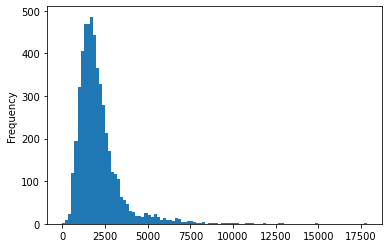

In [7]:
df['len'].plot.hist(bins=100)

In [8]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [9]:
# lower the text
df["content"] = df["content"].apply(lambda x: x.lower())

# Clean the text
df["content"] = df["content"].apply(lambda x: clean_text(x))

# Clean numbers
df["content"] = df["content"].apply(lambda x: clean_numbers(x))

In [10]:
df['category'].unique()

array(['Kitaifa', 'Biashara', 'michezo', 'Kimataifa', 'Burudani'],
      dtype=object)

In [11]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(df['content'], df['category'],
                                                    stratify=df['category'], 
                                                    test_size=0.25)

In [12]:
print("Train shape : ",train_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (3863,)
Test shape :  (1288,)


In [13]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y.values)
test_y = le.transform(test_y.values)

In [15]:
le.classes_

array(['Biashara', 'Burudani', 'Kimataifa', 'Kitaifa', 'michezo'],
      dtype=object)

In [16]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index):
    EMBEDDING_FILE = '/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/embeddings300.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [17]:
import os
word_index = tokenizer.word_index
embedings_index = {}
f = open(os.path.join('', '/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/embeddings300.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embedings_index[word] = coefs
f.close()

embedding_dimension = 300
num_words = len(word_index) + 1
embedings_matrix = np.zeros((num_words, embedding_dimension))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedings_vector = embedings_index.get(word)
    if embedings_vector is not None:
        embedings_matrix[i] = embedings_vector

In [18]:
np.shape(embedings_matrix)

(65660, 300)

In [19]:
embedding_matrix = embedings_matrix

In [20]:
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit


In [21]:
n_epochs = 6
model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/6 	 loss=451.9140 	 val_loss=294.0763  	 val_acc=0.6770  	 time=4.07s
Epoch 2/6 	 loss=307.6847 	 val_loss=272.5334  	 val_acc=0.7360  	 time=4.01s
Epoch 3/6 	 loss=276.6161 	 val_loss=254.0439  	 val_acc=0.7663  	 time=4.00s
Epoch 4/6 	 loss=259.1095 	 val_loss=238.9960  	 val_acc=0.7787  	 time=3.94s
Epoch 5/6 	 loss=239.6433 	 val_loss=231.5104  	 val_acc=0.7818  	 time=3.87s
Epoch 6/6 	 loss=228.3185 	 val_loss=221.4792  	 val_acc=0.8059  	 time=3.94s


In [22]:
torch.save(model,'/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/textcnn_model')

In [23]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

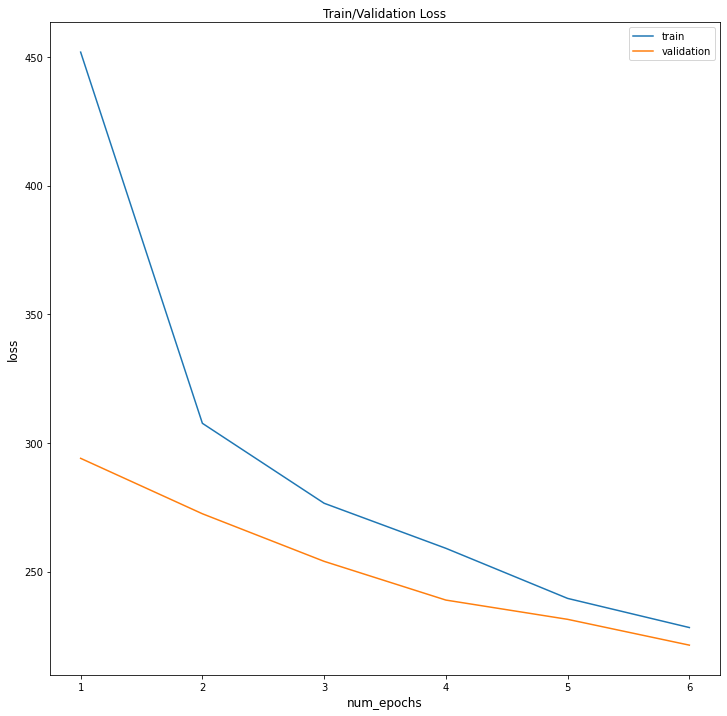

In [24]:
plot_graph(n_epochs)

In [28]:
!pip install scikit-plot

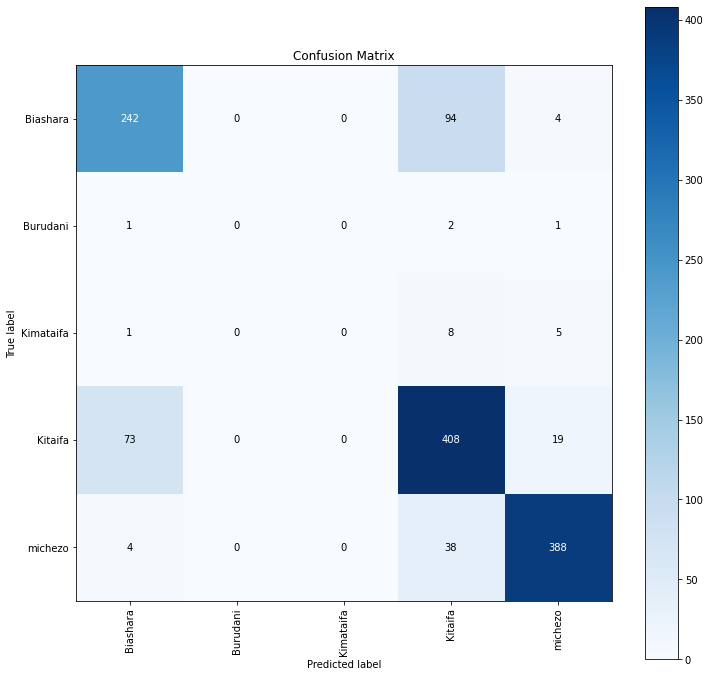

In [29]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

In [30]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [31]:
n_epochs = 6
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(test_X, dtype=torch.long).cuda()
y_cv = torch.tensor(test_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()

    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==test_y)/len(test_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/6 	 loss=692.1267 	 val_loss=527.7968  	 val_acc=0.6638  	 time=3.79s
Epoch 2/6 	 loss=548.1887 	 val_loss=429.3933  	 val_acc=0.6382  	 time=3.77s
Epoch 3/6 	 loss=437.2319 	 val_loss=333.1547  	 val_acc=0.6716  	 time=3.74s
Epoch 4/6 	 loss=341.7639 	 val_loss=288.2789  	 val_acc=0.6693  	 time=3.74s
Epoch 5/6 	 loss=311.1049 	 val_loss=288.6449  	 val_acc=0.6747  	 time=3.75s
Epoch 6/6 	 loss=299.8659 	 val_loss=280.1487  	 val_acc=0.7104  	 time=3.76s


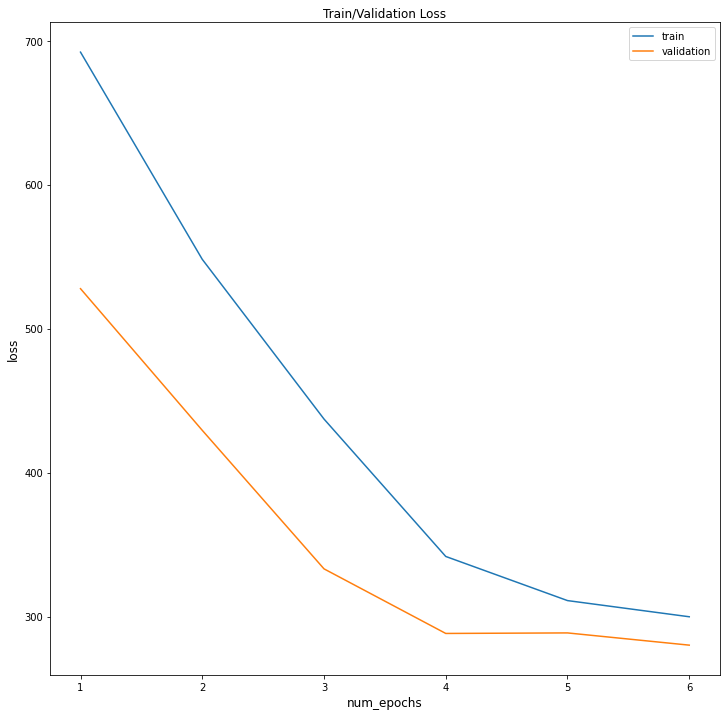

In [32]:
plot_graph(n_epochs)

In [33]:
torch.save(model,'/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/bilstm_model')

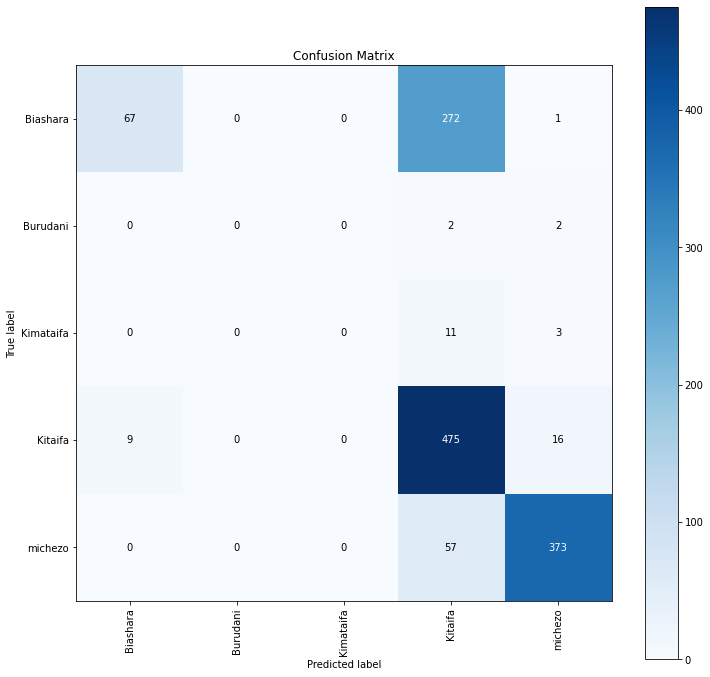

In [34]:
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

------

In [35]:
tdf = pd.read_csv(test_path)
tdf

,swahili_id,content
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,"MKUU wa Wilaya ya Bahi, Mkoani Dodoma, Mwanah..."
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,"MWISHONI mwa wiki hii, Timu ya Soka ya Taifa,..."
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,THAMANI ya mauzo ya bidhaa za Afrika Masharik...
3,00868eeee349e286303706ef0ffd851f39708d37,MENEJA Mawasiliano na Utetezi wa asasi ya AGP...
4,00a5cb12d3058dcf2e42f277eee599992db32412,"WAZIRI wa Kilimo, Japhet Hasunga amesema seri..."
...,...,...
1283,feb4b0ae88524c9cee3e50f2301d84a235f3c607,MKURUGENZI Msaidizi Msajili wa Asasi za kirai...
1284,fecf3f14f47237e02721ed4baa4eb6c11abd239f,Kilomoni alisema jana kesho atazungumzia sual...
1285,feed09e13586d12139cd59bc20996a4d29706606,"TIMU ya taifa ya soka ya Tanzania Bara, Kilim..."
1286,ffc0bca6fde8fa0cce1ac3a7b0d746603d441bf8,"YANGA imetozwa faini ya Sh 3,500,000 kutokana..."


In [36]:
x = tdf['content'].values[1]
print(x)

 MWISHONI mwa wiki hii, Timu ya Soka ya Taifa, Taifa Stars itakuwa na kibarua kizito dhidi ya Sudan, katika mechi ya kuwania kufuzu Fainali za Michuano ya Afrika kwa wachezaji wa ndani, Chan.Katika harakati za kujiandaa na mechi hiyo, Stars juzi ilicheza mechi ya kirafiki na Rwanda mjini Kigali na kutoka suluhu. Matokeo hayo yanaonekana kumridhisha kocha wa timu hiyo, Etienne Ndayiragije na kusema amepata kipimo sahihi kabla ya kucheza na Sudan mechi ambayo Stars inahitaji ushindi wa kuanzia mabao mawili kusonga mbele baada ya kupoteza mechi ya nyumbani kwa bao 1-0.Ndayiragije alisema waliingia kwenye mchezo wa juzi dhidi ya Rwanda wakiwa na malengo mawili kwanza kupata ushindi ili kujiweka mazingira mazuri kwenye viwango Fifa na pili kukiandaa kikosi hicho kwa mchezo dhidi ya Sudan.“Lengo la kwanza tumeshindwa kufanikiwa kwakuwa tumetoka sare na jambo linalofuatia nadhani kwa kiwango kikubwa tumefanikiwa kwa kupata kipimo sahihi cha kuweza kucheza na Sudan kwenye mchezo wa marudiano u

In [37]:
def predict_single(x):    
    # lower the text
    x = x.lower()
    # Clean the text
    x =  clean_text(x)
    # Clean numbers
    x =  clean_numbers(x)
    # Clean Contractions
    # x = replace_contractions(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]

In [39]:
res = predict_single(x)
print(type(res))
print(res)


<class 'str'>
michezo


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [40]:
tdf["category"] = tdf["content"].apply(lambda x: predict_single(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [43]:
tdf['kitaifa'], tdf['michezo'], tdf['biashara'], tdf['kimataifa'], tdf['burudani'] = [0,0,0,0,0]

In [46]:
df['category'].unique()

array(['Kitaifa', 'Biashara', 'michezo', 'Kimataifa', 'Burudani'],
      dtype=object)

In [49]:
def k_assign(x):
    if x == 'Kitaifa':
        val = 1
        return int(val)
    else:
        return 0

def m_assign(x):
    if x == 'michezo':
        val = 1
        return int(val)
    else:
        return 0

def b_assign(x):
    if x == 'Biashara':
        val = 1
        return int(val)
    else:
        return 0

def ki_assign(x):
    if x == 'Kimataifa':
        val = 1
        return int(val)
    else:
        return 0

def bu_assign(x):
    if x == 'Burudani':
        val = 1
        return int(val)
    else:
        return 0


In [50]:
tdf['kitaifa'] = tdf['category'].apply(lambda x: k_assign(x))
tdf['michezo'] = tdf['category'].apply(lambda x: m_assign(x))
tdf['biashara'] = tdf['category'].apply(lambda x: b_assign(x))
tdf['kimataifa'] = tdf['category'].apply(lambda x: ki_assign(x))
tdf['burudani'] = tdf['category'].apply(lambda x: bu_assign(x))

In [51]:
tdf

,swahili_id,content,category,kitaifa,michezo,biashara,kimataifa,burudani
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,"MKUU wa Wilaya ya Bahi, Mkoani Dodoma, Mwanah...",Kitaifa,1,0,0,0,0
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,"MWISHONI mwa wiki hii, Timu ya Soka ya Taifa,...",michezo,0,1,0,0,0
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,THAMANI ya mauzo ya bidhaa za Afrika Masharik...,Biashara,0,0,1,0,0
3,00868eeee349e286303706ef0ffd851f39708d37,MENEJA Mawasiliano na Utetezi wa asasi ya AGP...,Kitaifa,1,0,0,0,0
4,00a5cb12d3058dcf2e42f277eee599992db32412,"WAZIRI wa Kilimo, Japhet Hasunga amesema seri...",Kitaifa,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1283,feb4b0ae88524c9cee3e50f2301d84a235f3c607,MKURUGENZI Msaidizi Msajili wa Asasi za kirai...,Kitaifa,1,0,0,0,0
1284,fecf3f14f47237e02721ed4baa4eb6c11abd239f,Kilomoni alisema jana kesho atazungumzia sual...,michezo,0,1,0,0,0
1285,feed09e13586d12139cd59bc20996a4d29706606,"TIMU ya taifa ya soka ya Tanzania Bara, Kilim...",michezo,0,1,0,0,0
1286,ffc0bca6fde8fa0cce1ac3a7b0d746603d441bf8,"YANGA imetozwa faini ya Sh 3,500,000 kutokana...",michezo,0,1,0,0,0


In [52]:
del tdf['content']
del tdf['category']

In [53]:
tdf.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Swahili/sub.csv', index=False)